# BenchFS IOR Result Visualizer

`results/benchfs/*/ior_results/ior_result_*.json` から IOR のサマリ JSON を読み込み、操作別の帯域やレイテンシを可視化します。

In [1]:
from pathlib import Path
import json
import re

import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter
from IPython.display import display

# Plot style configuration
plt.rcParams.update({
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "axes.grid": True,
    "grid.alpha": 0.3,
})
pl.Config.set_tbl_rows(100)

DATA_DIR = (Path.cwd() / "processed" / "benchfsd").resolve()
DATA_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR = (Path.cwd() / "fig" / "benchfsd").resolve()
FIG_DIR.mkdir(parents=True, exist_ok=True)

def save(fig, name: str) -> None:
    for ext in ("png", "pdf"):
        fig.savefig(FIG_DIR / f"{name}.{ext}", bbox_inches="tight", dpi=150)

def comma_formatter(value, _):
    return f"{value:,.0f}"

def slugify(value: str) -> str:
    cleaned = re.sub(r"[^A-Za-z0-9._-]+", "_", value)
    return cleaned.strip("_") or "unknown"

In [2]:
def resolve_results_root() -> Path:
    candidates = [
        Path("results"),
        Path("..") / "results",
        Path("../..") / "results",
    ]
    for candidate in candidates:
        if candidate.exists():
            return candidate.resolve()
    raise FileNotFoundError("results ディレクトリが見つかりません。ノートブックの位置を確認してください。")

results_root = resolve_results_root()
print(f"Using results directory: {results_root}")

Using results directory: /work/0/NBB/rmaeda/workspace/rust/benchfs/results


In [3]:
def fix_ior_json(content: str) -> str:
    """Fix common IOR JSON output format bugs.
    
    IOR 4.0.0 has several JSON formatting issues:
    1. Double closing brackets after Results array: ]] -> ]
    2. Extra closing bracket at the end of tests array
    3. Trailing commas before closing braces/brackets
    """
    # Issue 1: Double closing bracket after Results array
    # Pattern: "Results": [ ... ]] , "max":
    content = re.sub(r'\]\s*\]\s*,\s*"max":', r'], "max":', content)
    
    # Issue 2: Extra closing bracket at the end of tests array  
    # Pattern: }]] , "summary": -> }] , "summary":
    content = re.sub(r'\}\s*\]\s*\]\s*,\s*"summary":', r'}], "summary":', content)
    
    # Issue 3: Trailing comma before closing brace
    content = re.sub(r',\s*\}', '}', content)
    
    # Issue 4: Trailing comma before closing bracket
    content = re.sub(r',\s*\]', ']', content)
    
    return content

def safe_load_json(path: Path) -> dict | None:
    """Load JSON file with automatic fix for IOR format issues."""
    try:
        content = path.read_text()
        # Try parsing as-is first
        try:
            return json.loads(content)
        except json.JSONDecodeError:
            pass
        # Apply fixes and retry
        fixed_content = fix_ior_json(content)
        return json.loads(fixed_content)
    except (OSError, json.JSONDecodeError) as exc:
        print(f"⚠️ Failed to parse {path}: {exc}")
        return None

In [4]:
IOR_JSON_PATTERN = re.compile(r"ior_result_(\d+)\.json$")

def parse_number(value):
    if value is None:
        return None
    if isinstance(value, (int, float)):
        return float(value)
    if isinstance(value, str):
        cleaned = value.replace(",", "").strip()
        if cleaned == "":
            return None
        try:
            return float(cleaned)
        except ValueError:
            return None
    return None

def parse_size(size_str: str) -> int | None:
    """Parse size string like '4m', '512m', '1g' to bytes."""
    if not size_str:
        return None
    size_str = size_str.lower().strip()
    multipliers = {'k': 1024, 'm': 1024**2, 'g': 1024**3, 't': 1024**4}
    for suffix, mult in multipliers.items():
        if size_str.endswith(suffix):
            try:
                return int(float(size_str[:-1]) * mult)
            except ValueError:
                return None
    try:
        return int(size_str)
    except ValueError:
        return None

def extract_params_from_command(command: str) -> dict:
    """Extract IOR parameters from command line string."""
    params = {}
    # Transfer size: -t 4m
    match = re.search(r'-t\s+(\S+)', command)
    if match:
        params['transfer_size_str'] = match.group(1)
    # Block size: -b 512m
    match = re.search(r'-b\s+(\S+)', command)
    if match:
        params['block_size_str'] = match.group(1)
    # File per proc: -F flag
    params['file_per_proc'] = 1 if ' -F' in command or command.endswith('-F') else 0
    return params

def load_ior_json(root: Path) -> tuple[pl.DataFrame, pl.DataFrame]:
    summary_records = []
    detail_records = []
    
    for path in sorted(root.glob("**/ior_results/ior_result_*.json")):
        data = safe_load_json(path)
        if data is None:
            continue
            
        rel_parts = path.relative_to(root).parts
        match = IOR_JSON_PATTERN.search(path.name)
        run_index = int(match.group(1)) if match else None
        
        command = data.get("Command line", "")
        cmd_params = extract_params_from_command(command)
        
        base = {
            "ior_file": str(path.relative_to(root)),
            "collection": "/".join(rel_parts[:-1]),
            "backend": rel_parts[0] if len(rel_parts) > 0 else "",
            "experiment": rel_parts[1] if len(rel_parts) > 1 else "",
            "run": rel_parts[2] if len(rel_parts) > 2 else "",
            "run_index": run_index,
        }
        
        began = data.get("Began", "")
        finished = data.get("Finished", "")
        
        for summary in data.get("summary", []) or []:
            record = base | {
                "command": command,
                "began": began,
                "finished": finished,
                "operation": summary.get("operation"),
                "bw_max_mib": parse_number(summary.get("bwMaxMIB")),
                "bw_min_mib": parse_number(summary.get("bwMinMIB")),
                "bw_mean_mib": parse_number(summary.get("bwMeanMIB")),
                "bw_std_mib": parse_number(summary.get("bwStdMIB")),
                "ops_max": parse_number(summary.get("OPsMax")),
                "ops_min": parse_number(summary.get("OPsMin")),
                "ops_mean": parse_number(summary.get("OPsMean")),
                "ops_std": parse_number(summary.get("OPsSD")),
                "mean_time": parse_number(summary.get("MeanTime")),
                "xsize_mib": parse_number(summary.get("xsizeMiB")),
                "block_size_bytes": parse_number(summary.get("blockSize")),
                "transfer_size_bytes": parse_number(summary.get("transferSize")),
                "segment_count": summary.get("segmentCount"),
                "num_tasks": summary.get("numTasks"),
                "tasks_per_node": summary.get("tasksPerNode"),
                "repetitions": summary.get("repetitions"),
                "file_per_proc": summary.get("filePerProc"),
                "transfer_size_str": cmd_params.get("transfer_size_str", ""),
                "block_size_str": cmd_params.get("block_size_str", ""),
            }
            summary_records.append(record)
            
        for test in data.get("tests", []) or []:
            parameters = test.get("Parameters", {}) or {}
            options = test.get("Options", {}) or {}
            results = test.get("Results", []) or []
            
            for result in results:
                if result.get("access") == "remove":
                    continue  # Skip remove operations
                detail_record = base | {
                    "command": command,
                    "test_id": test.get("TestID"),
                    "start_time": test.get("StartTime"),
                    "path": test.get("Path"),
                    "operation": result.get("access"),
                    "bw_mib": parse_number(result.get("bwMiB")),
                    "iops": parse_number(result.get("iops")),
                    "latency": parse_number(result.get("latency")),
                    "open_time": parse_number(result.get("openTime")),
                    "transfer_time": parse_number(result.get("wrRdTime")),
                    "close_time": parse_number(result.get("closeTime")),
                    "total_time": parse_number(result.get("totalTime")),
                    "block_kib": parse_number(result.get("blockKiB")),
                    "xfer_kib": parse_number(result.get("xferKiB")),
                    "segment_count": parameters.get("segmentCount"),
                    "transfer_size_bytes": parameters.get("transferSize"),
                    "block_size_bytes": parameters.get("blockSize"),
                    "num_tasks": options.get("tasks"),
                    "nodes": options.get("nodes"),
                    "tasks_per_node": options.get("clients per node"),
                    "transfer_size_str": cmd_params.get("transfer_size_str", ""),
                    "block_size_str": cmd_params.get("block_size_str", ""),
                    "file_per_proc": cmd_params.get("file_per_proc", 0),
                }
                detail_records.append(detail_record)
                
    summary_df = pl.DataFrame(summary_records) if summary_records else pl.DataFrame([])
    
    if not summary_df.is_empty():
        summary_df = (
            summary_df
            .with_columns(
                pl.col("num_tasks").cast(pl.Int64, strict=False),
                pl.col("tasks_per_node").cast(pl.Int64, strict=False),
                pl.col("repetitions").cast(pl.Int64, strict=False),
                pl.col("file_per_proc").cast(pl.Int64, strict=False),
                pl.col("segment_count").cast(pl.Int64, strict=False),
                (pl.col("block_size_bytes") / (1024 ** 2)).alias("block_size_mib"),
                (pl.col("transfer_size_bytes") / (1024 ** 2)).alias("transfer_size_mib"),
                (pl.col("bw_mean_mib") / 1024.0).alias("bw_mean_gib"),
                (pl.col("bw_max_mib") / 1024.0).alias("bw_max_gib"),
                (pl.col("bw_min_mib") / 1024.0).alias("bw_min_gib"),
            )
            .with_columns(
                pl.when(pl.col("file_per_proc") == 1)
                .then(pl.lit("File-per-Process"))
                .otherwise(pl.lit("Shared File"))
                .alias("access_mode"),
            )
            .sort(["backend", "experiment", "run", "run_index", "operation"])
        )
        
    detail_df = pl.DataFrame(detail_records) if detail_records else pl.DataFrame([])
    
    if not detail_df.is_empty():
        detail_df = (
            detail_df
            .with_columns(
                pl.col("num_tasks").cast(pl.Int64, strict=False),
                pl.col("nodes").cast(pl.Int64, strict=False),
                pl.col("tasks_per_node").cast(pl.Int64, strict=False),
                (pl.col("block_kib") / 1024.0).alias("block_mib"),
                (pl.col("xfer_kib") / 1024.0).alias("xfer_mib"),
                (pl.col("transfer_size_bytes") / (1024 ** 2)).alias("transfer_size_mib"),
                (pl.col("block_size_bytes") / (1024 ** 2)).alias("block_size_mib"),
                (pl.col("bw_mib") / 1024.0).alias("bw_gib"),
            )
            .with_columns(
                pl.when(pl.col("file_per_proc") == 1)
                .then(pl.lit("File-per-Process"))
                .otherwise(pl.lit("Shared File"))
                .alias("access_mode"),
            )
            .sort(["backend", "experiment", "run", "run_index", "operation", "test_id"])
        )
        
    return summary_df, detail_df

ior_summary_df, ior_detail_df = load_ior_json(results_root)

print(f"Loaded {len(ior_summary_df)} summary records and {len(ior_detail_df)} detail records")

if not ior_summary_df.is_empty():
    print(f"\nExperiments: {ior_summary_df['experiment'].unique().to_list()}")
    display(ior_summary_df.head(10).to_pandas())

Loaded 144 summary records and 144 detail records

Experiments: ['2025.11.27-09.29.18-large_scale']


,ior_file,collection,backend,experiment,run,run_index,command,began,finished,operation,...,repetitions,file_per_proc,transfer_size_str,block_size_str,block_size_mib,transfer_size_mib,bw_mean_gib,bw_max_gib,bw_min_gib,access_mode
0,benchfs/2025.11.27-09.29.18-large_scale/2025.1...,benchfs/2025.11.27-09.29.18-large_scale/2025.1...,benchfs,2025.11.27-09.29.18-large_scale,2025.11.27-09.29.34-379304.nqsv-2,0,/work/0/NBB/rmaeda/workspace/rust/benchfs/ior_...,Thu Nov 27 09:30:00 2025,Thu Nov 27 09:30:03 2025,read,...,1,1,4m,512m,512.0,4.0,4.521613,4.521613,4.521613,File-per-Process
1,benchfs/2025.11.27-09.29.18-large_scale/2025.1...,benchfs/2025.11.27-09.29.18-large_scale/2025.1...,benchfs,2025.11.27-09.29.18-large_scale,2025.11.27-09.29.34-379304.nqsv-2,0,/work/0/NBB/rmaeda/workspace/rust/benchfs/ior_...,Thu Nov 27 09:30:00 2025,Thu Nov 27 09:30:03 2025,write,...,1,1,4m,512m,512.0,4.0,3.614433,3.614433,3.614433,File-per-Process
2,benchfs/2025.11.27-09.29.18-large_scale/2025.1...,benchfs/2025.11.27-09.29.18-large_scale/2025.1...,benchfs,2025.11.27-09.29.18-large_scale,2025.11.27-09.29.34-379304.nqsv-2,1,/work/0/NBB/rmaeda/workspace/rust/benchfs/ior_...,Thu Nov 27 09:30:33 2025,Thu Nov 27 09:30:36 2025,read,...,1,0,4m,512m,512.0,4.0,4.732087,4.732087,4.732087,Shared File
3,benchfs/2025.11.27-09.29.18-large_scale/2025.1...,benchfs/2025.11.27-09.29.18-large_scale/2025.1...,benchfs,2025.11.27-09.29.18-large_scale,2025.11.27-09.29.34-379304.nqsv-2,1,/work/0/NBB/rmaeda/workspace/rust/benchfs/ior_...,Thu Nov 27 09:30:33 2025,Thu Nov 27 09:30:36 2025,write,...,1,0,4m,512m,512.0,4.0,3.706278,3.706278,3.706278,Shared File
4,benchfs/2025.11.27-09.29.18-large_scale/2025.1...,benchfs/2025.11.27-09.29.18-large_scale/2025.1...,benchfs,2025.11.27-09.29.18-large_scale,2025.11.27-09.29.34-379304.nqsv-2,2,/work/0/NBB/rmaeda/workspace/rust/benchfs/ior_...,Thu Nov 27 09:31:06 2025,Thu Nov 27 09:31:10 2025,read,...,1,1,4m,1g,1024.0,4.0,4.433007,4.433007,4.433007,File-per-Process
5,benchfs/2025.11.27-09.29.18-large_scale/2025.1...,benchfs/2025.11.27-09.29.18-large_scale/2025.1...,benchfs,2025.11.27-09.29.18-large_scale,2025.11.27-09.29.34-379304.nqsv-2,2,/work/0/NBB/rmaeda/workspace/rust/benchfs/ior_...,Thu Nov 27 09:31:06 2025,Thu Nov 27 09:31:10 2025,write,...,1,1,4m,1g,1024.0,4.0,4.007191,4.007191,4.007191,File-per-Process
6,benchfs/2025.11.27-09.29.18-large_scale/2025.1...,benchfs/2025.11.27-09.29.18-large_scale/2025.1...,benchfs,2025.11.27-09.29.18-large_scale,2025.11.27-09.29.34-379304.nqsv-2,3,/work/0/NBB/rmaeda/workspace/rust/benchfs/ior_...,Thu Nov 27 09:31:41 2025,Thu Nov 27 09:31:45 2025,read,...,1,0,4m,1g,1024.0,4.0,4.356850,4.356850,4.356850,Shared File
7,benchfs/2025.11.27-09.29.18-large_scale/2025.1...,benchfs/2025.11.27-09.29.18-large_scale/2025.1...,benchfs,2025.11.27-09.29.18-large_scale,2025.11.27-09.29.34-379304.nqsv-2,3,/work/0/NBB/rmaeda/workspace/rust/benchfs/ior_...,Thu Nov 27 09:31:41 2025,Thu Nov 27 09:31:45 2025,write,...,1,0,4m,1g,1024.0,4.0,3.906284,3.906284,3.906284,Shared File
8,benchfs/2025.11.27-09.29.18-large_scale/2025.1...,benchfs/2025.11.27-09.29.18-large_scale/2025.1...,benchfs,2025.11.27-09.29.18-large_scale,2025.11.27-09.29.34-379304.nqsv-2,4,/work/0/NBB/rmaeda/workspace/rust/benchfs/ior_...,Thu Nov 27 09:32:16 2025,Thu Nov 27 09:32:24 2025,read,...,1,1,4m,2g,2048.0,4.0,4.511951,4.511951,4.511951,File-per-Process
9,benchfs/2025.11.27-09.29.18-large_scale/2025.1...,benchfs/2025.11.27-09.29.18-large_scale/2025.1...,benchfs,2025.11.27-09.29.18-large_scale,2025.11.27-09.29.34-379304.nqsv-2,4,/work/0/NBB/rmaeda/workspace/rust/benchfs/ior_...,Thu Nov 27 09:32:16 2025,Thu Nov 27 09:32:24 2025,write,...,1,1,4m,2g,2048.0,4.0,4.001895,4.001895,4.001895,File-per-Process


## Summary Overview

IOR JSONサマリを実験 × 実行 × 操作単位で整形したテーブルを確認します。

In [5]:
if ior_summary_df.is_empty():
    print("No IOR summary rows to show.")
else:
    overview = (
        ior_summary_df
        .select(
            "backend",
            "experiment",
            "run",
            "run_index",
            "operation",
            "access_mode",
            "block_size_str",
            "transfer_size_str",
            "bw_mean_mib",
            "bw_mean_gib",
            "mean_time",
            "num_tasks",
            "tasks_per_node",
        )
        .sort(["backend", "experiment", "run", "run_index", "operation"])
    )
    display(overview.to_pandas())

,backend,experiment,run,run_index,operation,access_mode,block_size_str,transfer_size_str,bw_mean_mib,bw_mean_gib,mean_time,num_tasks,tasks_per_node
0,benchfs,2025.11.27-09.29.18-large_scale,2025.11.27-09.29.34-379304.nqsv-2,0,read,File-per-Process,512m,4m,4630.1321,4.521613,0.8846,8,4
1,benchfs,2025.11.27-09.29.18-large_scale,2025.11.27-09.29.34-379304.nqsv-2,0,write,File-per-Process,512m,4m,3701.1796,3.614433,1.1067,8,4
2,benchfs,2025.11.27-09.29.18-large_scale,2025.11.27-09.29.34-379304.nqsv-2,1,read,Shared File,512m,4m,4845.6568,4.732087,0.8453,8,4
3,benchfs,2025.11.27-09.29.18-large_scale,2025.11.27-09.29.34-379304.nqsv-2,1,write,Shared File,512m,4m,3795.2287,3.706278,1.0792,8,4
4,benchfs,2025.11.27-09.29.18-large_scale,2025.11.27-09.29.34-379304.nqsv-2,2,read,File-per-Process,1g,4m,4539.3992,4.433007,1.8046,8,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,benchfs,2025.11.27-09.29.18-large_scale,2025.11.27-09.30.36-379307.nqsv-16,15,write,Shared File,1g,4m,25293.0914,24.700285,10.3643,256,16
140,benchfs,2025.11.27-09.29.18-large_scale,2025.11.27-09.30.36-379307.nqsv-16,16,read,File-per-Process,2g,4m,4433.6292,4.329716,118.2526,256,16
141,benchfs,2025.11.27-09.29.18-large_scale,2025.11.27-09.30.36-379307.nqsv-16,16,write,File-per-Process,2g,4m,22832.4376,22.297302,22.9624,256,16
142,benchfs,2025.11.27-09.29.18-large_scale,2025.11.27-09.30.36-379307.nqsv-16,17,read,Shared File,2g,4m,3556.4603,3.473106,147.4185,256,16


## Select Experiment

分析対象の実験を選択します。

In [6]:
# 実験を選択（最新の実験をデフォルトで選択）
if not ior_detail_df.is_empty():
    available_experiments = ior_detail_df["experiment"].unique().sort(descending=True).to_list()
    print("Available experiments:")
    for i, exp in enumerate(available_experiments):
        print(f"  [{i}] {exp}")
    
    # 最新の実験を選択
    SELECTED_EXPERIMENT = available_experiments[0] if available_experiments else None
    print(f"\nSelected: {SELECTED_EXPERIMENT}")
else:
    SELECTED_EXPERIMENT = None
    print("No experiments available")

Available experiments:
  [0] 2025.11.27-09.29.18-large_scale

Selected: 2025.11.27-09.29.18-large_scale


## Bandwidth by Block Size

ブロックサイズ別のRead/Write帯域を比較します。

/tmp/ipykernel_2088816/2446348065.py:24: DeprecationWarning: the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.
  pivot_df = grouped.pivot(


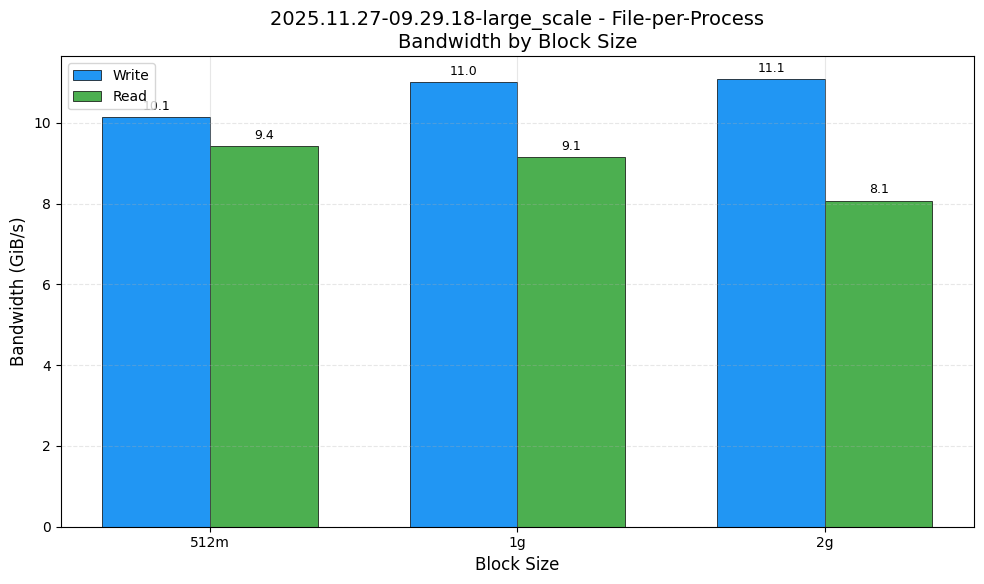

/tmp/ipykernel_2088816/2446348065.py:24: DeprecationWarning: the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.
  pivot_df = grouped.pivot(


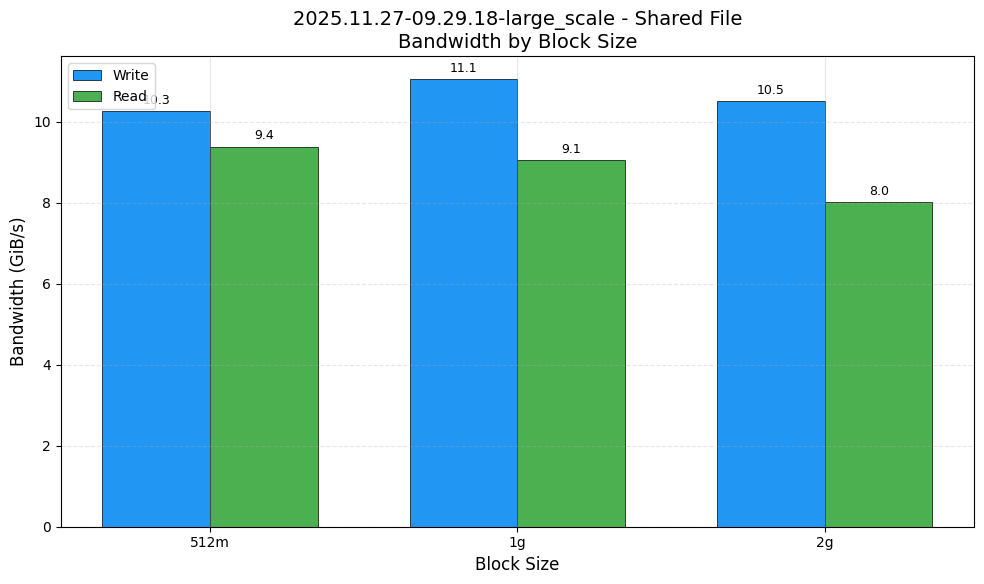

In [7]:
if ior_detail_df.is_empty() or SELECTED_EXPERIMENT is None:
    print("No data to plot.")
else:
    exp_df = ior_detail_df.filter(pl.col("experiment") == SELECTED_EXPERIMENT)
    
    for access_mode in ["File-per-Process", "Shared File"]:
        mode_df = exp_df.filter(pl.col("access_mode") == access_mode)
        if mode_df.is_empty():
            continue
            
        # Group by block size and operation
        grouped = (
            mode_df
            .group_by(["block_size_str", "operation"])
            .agg([
                pl.col("bw_gib").mean().alias("bw_gib_mean"),
                pl.col("bw_gib").std().alias("bw_gib_std"),
                pl.col("bw_mib").mean().alias("bw_mib_mean"),
            ])
            .sort("block_size_str")
        )
        
        # Pivot for plotting
        pivot_df = grouped.pivot(
            values="bw_gib_mean",
            index="block_size_str",
            columns="operation"
        ).to_pandas().set_index("block_size_str")
        
        # Sort by block size
        size_order = ['64m', '256m', '512m', '1g', '2g', '4g']
        pivot_df = pivot_df.reindex([s for s in size_order if s in pivot_df.index])
        
        if pivot_df.empty:
            continue
        
        fig, ax = plt.subplots(figsize=(10, 6))
        
        x = range(len(pivot_df))
        width = 0.35
        
        colors = {'write': '#2196F3', 'read': '#4CAF50'}
        
        if 'write' in pivot_df.columns:
            ax.bar([i - width/2 for i in x], pivot_df['write'], width, 
                   label='Write', color=colors['write'], edgecolor='black', linewidth=0.5)
        if 'read' in pivot_df.columns:
            ax.bar([i + width/2 for i in x], pivot_df['read'], width,
                   label='Read', color=colors['read'], edgecolor='black', linewidth=0.5)
        
        ax.set_xlabel('Block Size')
        ax.set_ylabel('Bandwidth (GiB/s)')
        ax.set_title(f'{SELECTED_EXPERIMENT} - {access_mode}\nBandwidth by Block Size')
        ax.set_xticks(x)
        ax.set_xticklabels(pivot_df.index)
        ax.legend(loc='upper left')
        ax.grid(axis='y', alpha=0.3, linestyle='--')
        
        # Add value labels on bars
        for bars in ax.containers:
            ax.bar_label(bars, fmt='%.1f', padding=3, fontsize=9)
        
        plt.tight_layout()
        save(fig, f"bandwidth_by_blocksize_{slugify(SELECTED_EXPERIMENT)}_{slugify(access_mode)}")
        plt.show()
        plt.close(fig)

## Scalability Analysis

ノード数・プロセス数に対するスケーラビリティを確認します。

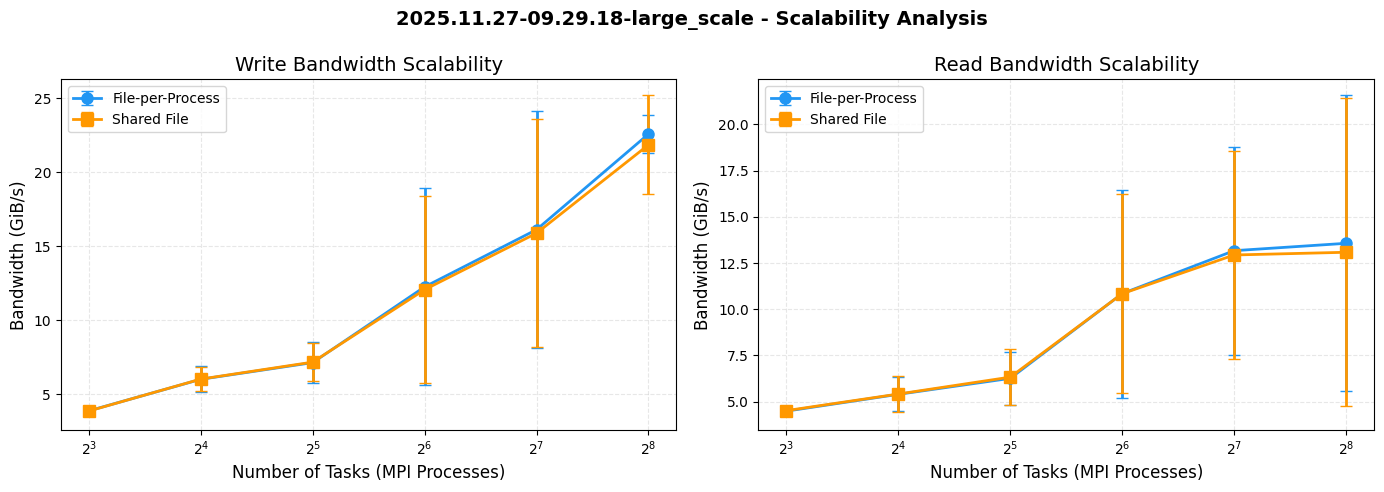

In [8]:
if ior_detail_df.is_empty() or SELECTED_EXPERIMENT is None:
    print("No data to plot.")
else:
    exp_df = ior_detail_df.filter(pl.col("experiment") == SELECTED_EXPERIMENT)
    
    # Group by num_tasks and operation
    scalability = (
        exp_df
        .group_by(["num_tasks", "operation", "access_mode"])
        .agg([
            pl.col("bw_gib").mean().alias("bw_gib_mean"),
            pl.col("bw_gib").std().alias("bw_gib_std"),
            pl.col("nodes").first().alias("nodes"),
        ])
        .sort("num_tasks")
    )
    
    if scalability.is_empty():
        print("No scalability data available.")
    else:
        pdf = scalability.to_pandas()
        
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        for ax, operation in zip(axes, ['write', 'read']):
            op_df = pdf[pdf['operation'] == operation]
            
            for access_mode, marker, color in [('File-per-Process', 'o', '#2196F3'), ('Shared File', 's', '#FF9800')]:
                mode_df = op_df[op_df['access_mode'] == access_mode]
                if mode_df.empty:
                    continue
                ax.errorbar(
                    mode_df['num_tasks'],
                    mode_df['bw_gib_mean'],
                    yerr=mode_df['bw_gib_std'].fillna(0),
                    marker=marker,
                    markersize=8,
                    linewidth=2,
                    capsize=4,
                    label=access_mode,
                    color=color,
                )
            
            ax.set_xlabel('Number of Tasks (MPI Processes)')
            ax.set_ylabel('Bandwidth (GiB/s)')
            ax.set_title(f'{operation.capitalize()} Bandwidth Scalability')
            ax.legend()
            ax.grid(alpha=0.3, linestyle='--')
            ax.set_xscale('log', base=2)
        
        fig.suptitle(f'{SELECTED_EXPERIMENT} - Scalability Analysis', fontsize=14, fontweight='bold')
        plt.tight_layout()
        save(fig, f"scalability_{slugify(SELECTED_EXPERIMENT)}")
        plt.show()
        plt.close(fig)

## Read vs Write Comparison

Read/Writeの帯域比較を散布図で可視化します。

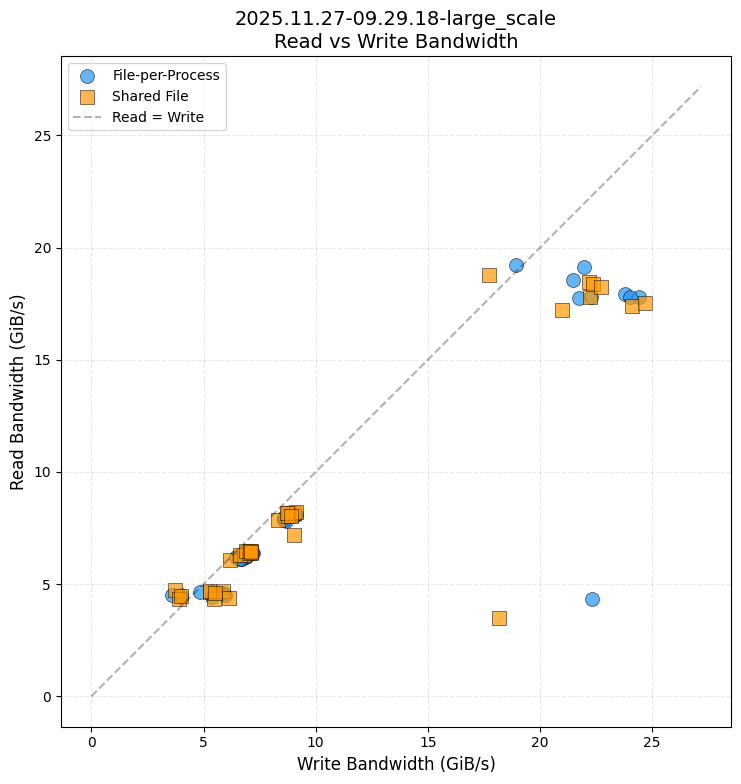

In [9]:
if ior_detail_df.is_empty() or SELECTED_EXPERIMENT is None:
    print("No data to plot.")
else:
    exp_df = ior_detail_df.filter(pl.col("experiment") == SELECTED_EXPERIMENT)
    
    # Get write and read data per run
    write_df = exp_df.filter(pl.col("operation") == "write").select(
        "run_index", "access_mode", "block_size_str", "num_tasks",
        pl.col("bw_gib").alias("write_bw_gib")
    )
    read_df = exp_df.filter(pl.col("operation") == "read").select(
        "run_index", "access_mode", "block_size_str", "num_tasks",
        pl.col("bw_gib").alias("read_bw_gib")
    )
    
    merged = write_df.join(
        read_df,
        on=["run_index", "access_mode", "block_size_str", "num_tasks"],
        how="inner"
    ).to_pandas()
    
    if merged.empty:
        print("No paired write/read data available.")
    else:
        fig, ax = plt.subplots(figsize=(8, 8))
        
        colors = {'File-per-Process': '#2196F3', 'Shared File': '#FF9800'}
        markers = {'File-per-Process': 'o', 'Shared File': 's'}
        
        for mode in merged['access_mode'].unique():
            mode_df = merged[merged['access_mode'] == mode]
            ax.scatter(
                mode_df['write_bw_gib'],
                mode_df['read_bw_gib'],
                c=colors.get(mode, 'gray'),
                marker=markers.get(mode, 'o'),
                s=100,
                alpha=0.7,
                edgecolors='black',
                linewidths=0.5,
                label=mode
            )
        
        # Add diagonal line (read = write)
        max_val = max(merged['write_bw_gib'].max(), merged['read_bw_gib'].max()) * 1.1
        ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.3, label='Read = Write')
        
        ax.set_xlabel('Write Bandwidth (GiB/s)')
        ax.set_ylabel('Read Bandwidth (GiB/s)')
        ax.set_title(f'{SELECTED_EXPERIMENT}\nRead vs Write Bandwidth')
        ax.legend()
        ax.grid(alpha=0.3, linestyle='--')
        ax.set_aspect('equal')
        
        plt.tight_layout()
        save(fig, f"read_vs_write_{slugify(SELECTED_EXPERIMENT)}")
        plt.show()
        plt.close(fig)

## Bandwidth by Run Index

同一ジョブ内の run_index ごとの帯域推移を確認します。

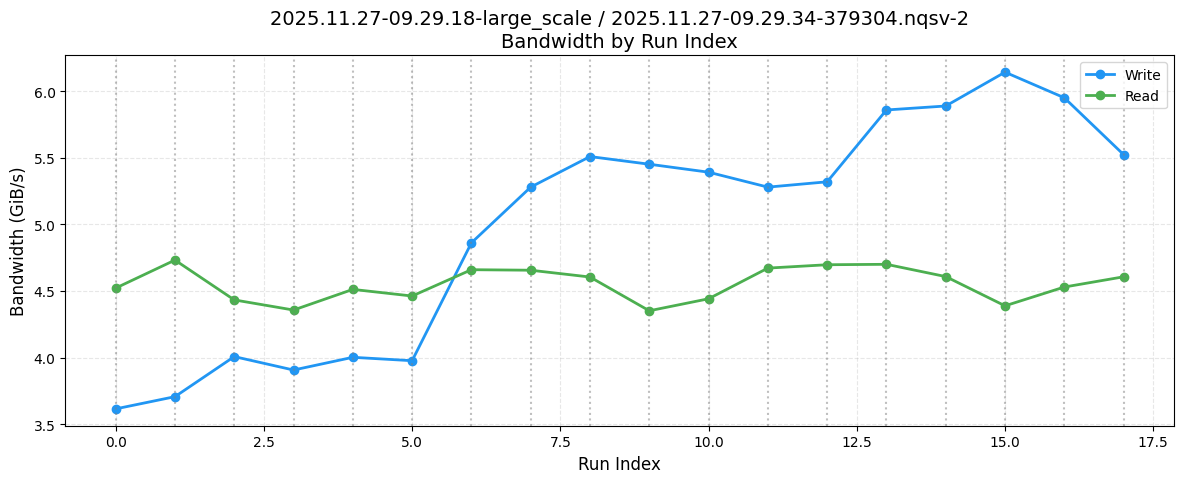

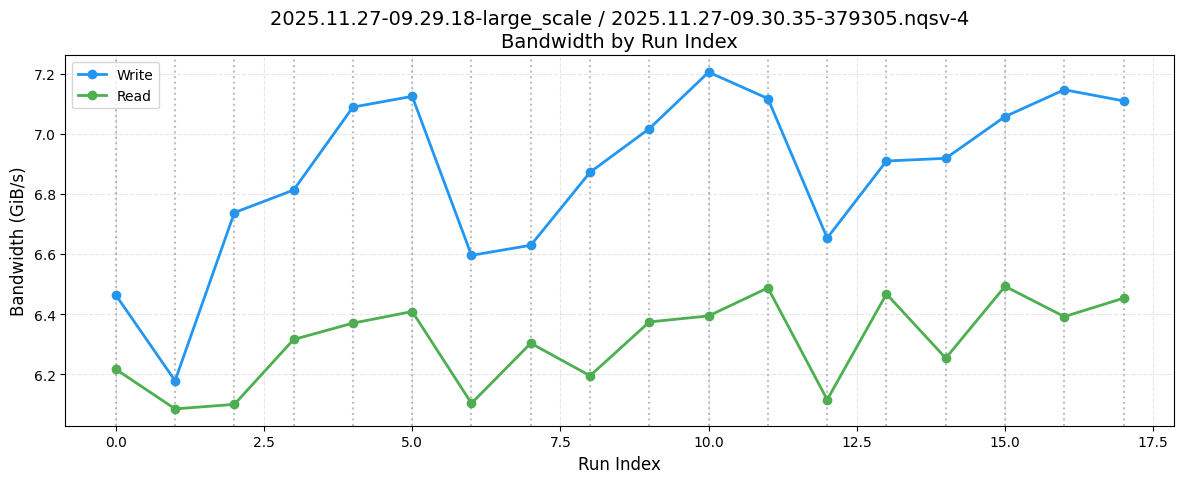

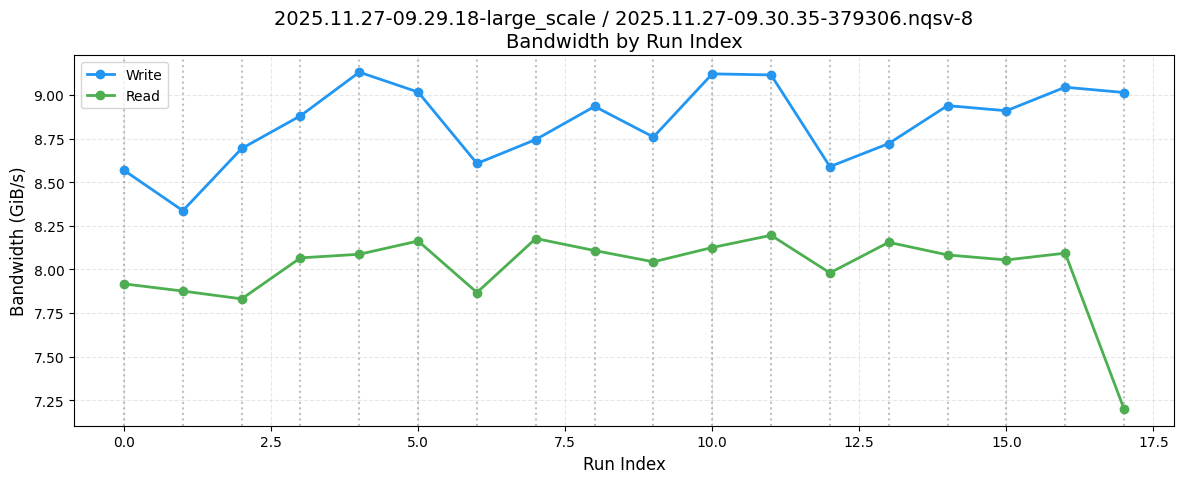

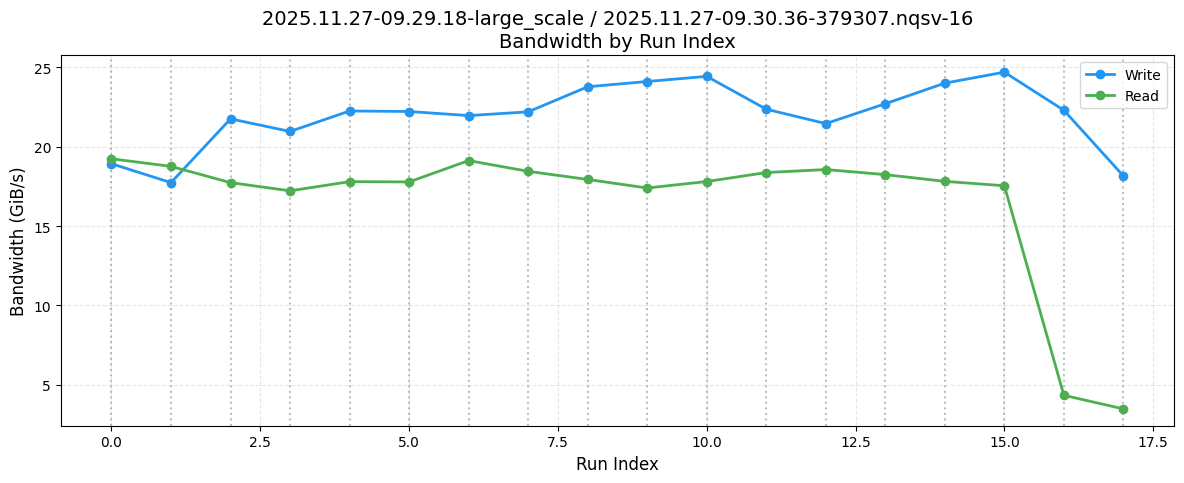

In [10]:
if ior_detail_df.is_empty() or SELECTED_EXPERIMENT is None:
    print("No IOR data to plot.")
else:
    exp_df = ior_detail_df.filter(pl.col("experiment") == SELECTED_EXPERIMENT)
    
    for run_df in exp_df.partition_by("run", maintain_order=True):
        run = run_df[0, "run"] or "unknown"
        
        tidy = (
            run_df
            .select("run_index", "operation", "bw_gib", "access_mode", "block_size_str")
            .drop_nulls("bw_gib")
            .sort(["operation", "run_index"])
        ).to_pandas()
        
        if tidy.empty:
            continue
        
        fig, ax = plt.subplots(figsize=(12, 5))
        
        colors = {'write': '#2196F3', 'read': '#4CAF50'}
        
        for operation in ['write', 'read']:
            op_df = tidy[tidy['operation'] == operation]
            ax.plot(
                op_df['run_index'],
                op_df['bw_gib'],
                marker='o',
                linewidth=2,
                markersize=6,
                label=operation.capitalize(),
                color=colors[operation],
            )
        
        ax.set_xlabel('Run Index')
        ax.set_ylabel('Bandwidth (GiB/s)')
        ax.set_title(f'{SELECTED_EXPERIMENT} / {run}\nBandwidth by Run Index')
        ax.grid(alpha=0.3, linestyle='--')
        ax.legend()
        
        # Add annotations for configuration changes
        prev_config = None
        for _, row in tidy[tidy['operation'] == 'write'].iterrows():
            config = f"{row['block_size_str']}/{row['access_mode'][:1]}"
            if config != prev_config:
                ax.axvline(x=row['run_index'], color='gray', linestyle=':', alpha=0.5)
                prev_config = config
        
        plt.tight_layout()
        save(fig, f"bandwidth_run_index_{slugify(SELECTED_EXPERIMENT)}_{slugify(run)}")
        plt.show()
        plt.close(fig)

## Summary Statistics Table

実験の統計サマリを表形式で表示します。

In [11]:
if ior_detail_df.is_empty() or SELECTED_EXPERIMENT is None:
    print("No data available.")
else:
    exp_df = ior_detail_df.filter(pl.col("experiment") == SELECTED_EXPERIMENT)
    
    stats = (
        exp_df
        .group_by(["access_mode", "operation", "block_size_str"])
        .agg([
            pl.col("bw_gib").mean().round(2).alias("Mean (GiB/s)"),
            pl.col("bw_gib").max().round(2).alias("Max (GiB/s)"),
            pl.col("bw_gib").min().round(2).alias("Min (GiB/s)"),
            pl.col("bw_gib").std().round(2).alias("Std (GiB/s)"),
            pl.len().alias("Samples"),
        ])
        .sort(["access_mode", "operation", "block_size_str"])
    )
    
    print(f"\n{SELECTED_EXPERIMENT} - Summary Statistics\n")
    display(stats.to_pandas())


2025.11.27-09.29.18-large_scale - Summary Statistics



,access_mode,operation,block_size_str,Mean (GiB/s),Max (GiB/s),Min (GiB/s),Std (GiB/s),Samples
0,File-per-Process,read,1g,9.14,17.94,4.43,5.39,12
1,File-per-Process,read,2g,8.07,17.81,4.33,4.77,12
2,File-per-Process,read,512m,9.42,19.24,4.52,5.89,12
3,File-per-Process,write,1g,11.00,24.01,4.01,7.50,12
4,File-per-Process,write,2g,11.09,24.44,4.00,7.36,12
5,File-per-Process,write,512m,10.13,21.96,3.61,6.63,12
6,Shared File,read,1g,9.05,17.54,4.35,5.21,12
7,Shared File,read,2g,8.02,18.37,3.47,4.92,12
8,Shared File,read,512m,9.38,18.76,4.66,5.63,12
9,Shared File,write,1g,11.06,24.70,3.91,7.55,12


## Export Processed Data

整形済みのサマリと詳細データをJSONとして保存します。

In [12]:
if ior_summary_df.is_empty() and ior_detail_df.is_empty():
    print("No IOR results to export.")
else:
    if not ior_summary_df.is_empty():
        summary_out = DATA_DIR / "ior_summary.json"
        summary_out.parent.mkdir(parents=True, exist_ok=True)
        summary_out.write_text(
            json.dumps(ior_summary_df.to_pandas().to_dict(orient="records"), ensure_ascii=False, indent=2)
        )
        print(f"Wrote {summary_out}")
    else:
        print("No summary records to export.")
        
    if not ior_detail_df.is_empty():
        detail_out = DATA_DIR / "ior_detail.json"
        detail_out.parent.mkdir(parents=True, exist_ok=True)
        detail_out.write_text(
            json.dumps(ior_detail_df.to_pandas().to_dict(orient="records"), ensure_ascii=False, indent=2)
        )
        print(f"Wrote {detail_out}")
    else:
        print("No detailed records to export.")

Wrote /work/0/NBB/rmaeda/workspace/rust/benchfs/plot/processed/benchfsd/ior_summary.json
Wrote /work/0/NBB/rmaeda/workspace/rust/benchfs/plot/processed/benchfsd/ior_detail.json
